# Plots generation and miscellaneous attempts

# You enter at your own risk_

Import

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import optim, nn
from torch.autograd import Variable
from torch.utils.data import DataLoader

from dataset import Dataset
from diceLoss import DiceLoss
from net import UNet

Variables

In [140]:
# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Define training parameters
LEARNING_RATE = 1e-4
BATCH_SIZE = 8
EPOCHS = 5
NUM_WORKERS = 8

v_dict = {
    1: 'C1', 2: 'C2', 3: 'C3', 4: 'C4', 5: 'C5', 6: 'C6', 7: 'C7',
    8: 'T1', 9: 'T2', 10: 'T3', 11: 'T4', 12: 'T5', 13: 'T6', 14: 'T7',
    15: 'T8', 16: 'T9', 17: 'T10', 18: 'T11', 19: 'T12', 20: 'L1',
    21: 'L2', 22: 'L3', 23: 'L4', 24: 'L5', 25: 'L6', 26: 'Sacrum',
    27: 'Cocc', 28: 'T13'
}

data_folder = "./data/processed/"

train_data_dir = data_folder + "train/"
validation_data_dir = data_folder + "validation/"
test_data_dir = data_folder + "test/"

train_images_dir = train_data_dir + "images/"
train_masks_dir = train_data_dir + "masks/"
validation_images_dir = validation_data_dir + "images/"
validation_masks_dir = validation_data_dir + "masks/"
test_images_dir = test_data_dir + "images/"
test_masks_dir = test_data_dir + "masks/"

Read folders

In [141]:
# Get name of every image (same as corresponding mask name)
train_images_paths = os.listdir(train_images_dir)
validation_images_paths = os.listdir(validation_images_dir)
test_images_paths = os.listdir(test_images_dir)
# train_masks_paths = os.listdir(train_masks_dir)
# validation_masks_paths = os.listdir(validation_masks_dir)
# test_masks_paths = os.listdir(test_masks_dir)

# Load both images and masks data
train_dataset = Dataset(train_images_dir, train_masks_dir, train_images_paths)
# valid_dataset = Dataset(validation_images_dir, validation_masks_dir, validation_images_paths)
# test_dataset = Dataset(test_images_dir, test_masks_dir, test_images_paths)

# Create PyTorch DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
# valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
# test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Choose image

In [142]:
iterator = iter(train_dataloader)
for i in range(10):
    next_image = next(iterator)

# -----Restart kernel after each case-----

bc of jupiter notebooks memory management

# Case 1

Train_loss: 0.5499936938285828
['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'T1', 'T2', 'T3', 'T4', 'T5']
['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'T1', 'T2', 'T3', 'T4', 'T5', 'L5']


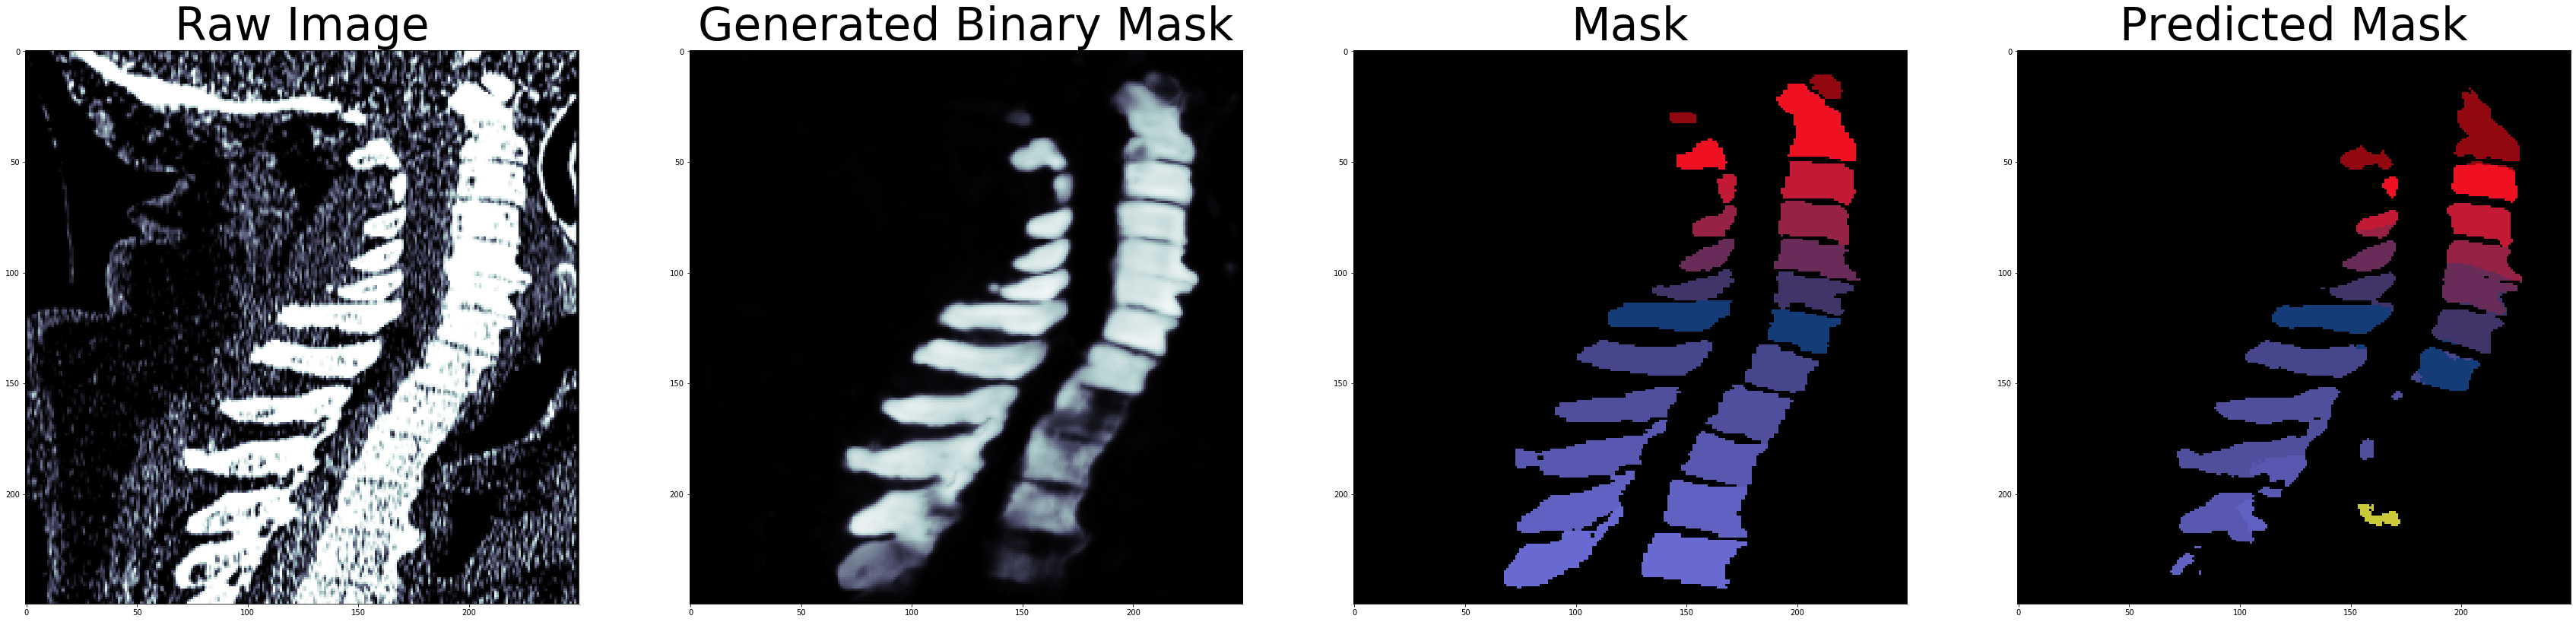

In [5]:
# Define models
model = UNet(n_channels=2, n_classes=29)
model.to(device=device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
checkpoint = torch.load("./unet_model_m_intFx.pth")
model.load_state_dict(checkpoint['model_state_dict'])
model_s = UNet(n_channels=1, n_classes=2)
model_s.to(device=device)
checkpoint_s = torch.load("./unet_model_fx_4.pth")
model_s.load_state_dict(checkpoint_s['model_state_dict'])

# Predict
image = next_image['image'].to(DEVICE)
mask = next_image['mask'].long().to(DEVICE)
outputs_s = model_s(image)
outputs_s = torch.sigmoid(outputs_s)
image_prep_1 = torch.cat((image, outputs_s[:, 1, :, :].unsqueeze(1)), 1)
outputs_m_1 = model(image_prep_1)

#Get colors
pred_mask = np.argmax(outputs_m_1.detach().cpu().numpy(), axis=1)
colors_mask, counts_mask = np.unique(next_image['mask'][0][:, :], return_counts=True)
colors, counts = np.unique(pred_mask[0], return_counts=True)
mask_dict = dict(zip(colors_mask, counts_mask))
pred_dict = dict(zip(colors, counts))
pred_dict = {key: val for key, val in pred_dict.items() if val > 100}
mask_list = [val for key, val in v_dict.items() if key in mask_dict]
pred_list = [val for key, val in v_dict.items() if key in pred_dict]
new_mask_1 = pred_mask[0] - 1

# Prints
loss = nn.CrossEntropyLoss()(outputs_m_1, mask)
train_loss = loss.item()
print("Train_loss: {0}".format(train_loss))
print(mask_list)
print(pred_list)

# Plot
fig, ax = plt.subplots(1, 4, figsize=(60, 60))
ax[0].imshow(image[0, 0, :, :].detach().cpu().numpy(), cmap='bone', vmin=0, vmax=255)
ax[0].set_title("Raw Image", fontsize=60)
ax[1].imshow(image_prep_1[0, 1, :, :].detach().cpu().numpy(), cmap='bone', vmin=0, vmax=1)
ax[1].set_title("Generated Binary Mask", fontsize=60)
ax[2].imshow(mask[0, :, :].cpu(), cmap='gist_stern', vmin=0, vmax=29)
ax[2].set_title("Mask", fontsize=60)
ax[3].imshow(new_mask_1, cmap='gist_stern', vmin=0, vmax=29)
ax[3].set_title("Predicted Mask", fontsize=60)
plt.show()

# Case 2

Train_loss: 0.3660910129547119
['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'T1', 'T2', 'T3', 'T4', 'T5']
['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'T1', 'T2', 'T3', 'T4', 'T5', 'T7', 'L5']


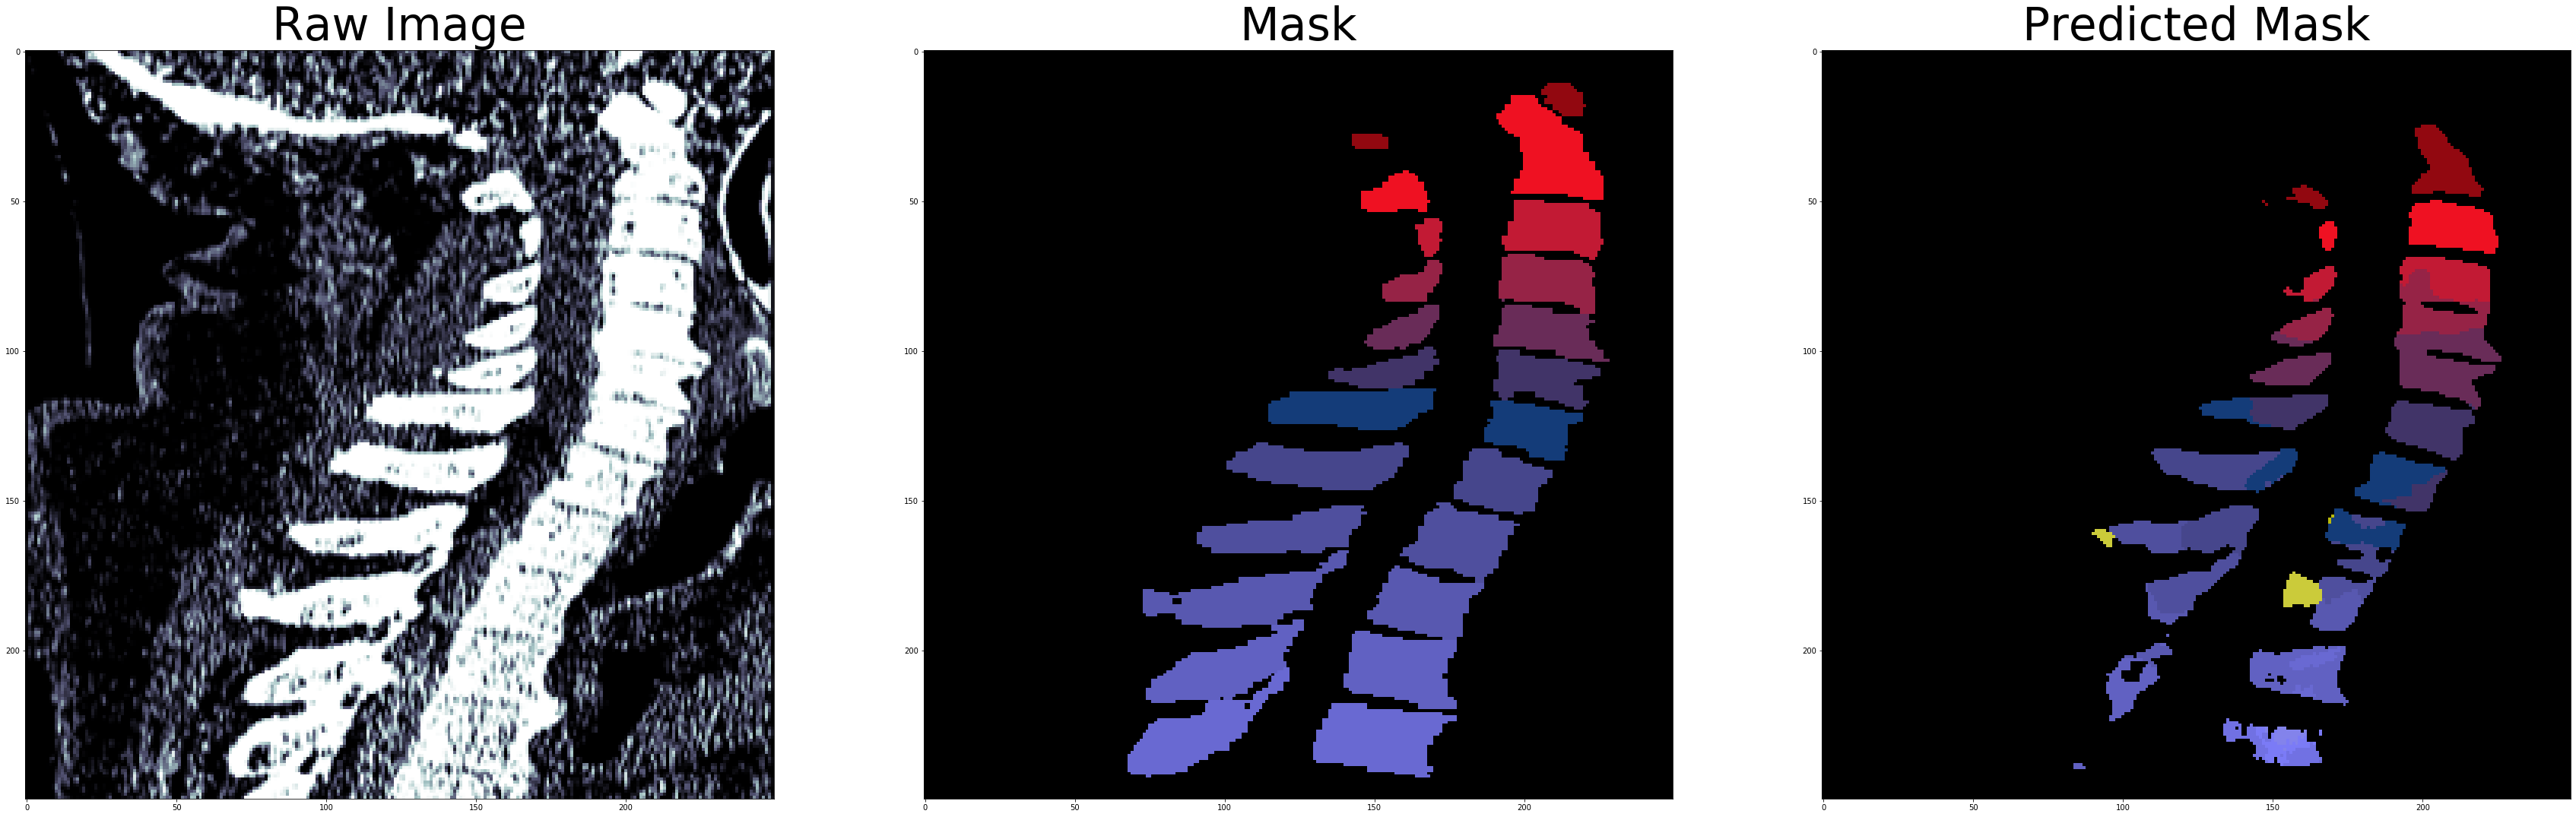

In [6]:
# Define models
model = UNet(n_channels=1, n_classes=29)
model.to(device=device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
checkpoint = torch.load("./unet_model_m_s_intFx.pth")
model.load_state_dict(checkpoint['model_state_dict'])
model_s = UNet(n_channels=1, n_classes=2)
model_s.to(device=device)
checkpoint_s = torch.load("./unet_model_fx_4.pth")
model_s.load_state_dict(checkpoint_s['model_state_dict'])

# Predict
image = next_image['image'].to(DEVICE)
mask = next_image['mask'].long().to(DEVICE)
outputs_s = model_s(image)
outputs_s = torch.sigmoid(outputs_s)
image_prep_2 = image
outputs_m_2 = model(image_prep_2)

#Get colors
pred_mask = np.argmax(outputs_m_2.detach().cpu().numpy(), axis=1)
colors_mask, counts_mask = np.unique(next_image['mask'][0][:, :], return_counts=True)
colors, counts = np.unique(pred_mask[0], return_counts=True)
mask_dict = dict(zip(colors_mask, counts_mask))
pred_dict = dict(zip(colors, counts))
pred_dict = {key: val for key, val in pred_dict.items() if val > 100}
mask_list = [val for key, val in v_dict.items() if key in mask_dict]
pred_list = [val for key, val in v_dict.items() if key in pred_dict]
new_mask_2 = pred_mask[0] - 1

# Prints
loss = nn.CrossEntropyLoss()(outputs_m_2, mask)
train_loss = loss.item()
print("Train_loss: {0}".format(train_loss))
print(mask_list)
print(pred_list)

# Plot
fig, ax = plt.subplots(1, 3, figsize=(60, 60))
ax[0].imshow(image[0, 0, :, :].detach().cpu().numpy(), cmap='bone', vmin=0, vmax=255)
ax[0].set_title("Raw Image", fontsize=60)
ax[1].imshow(mask[0, :, :].cpu(), cmap='gist_stern', vmin=0, vmax=29)
ax[1].set_title("Mask", fontsize=60)
ax[2].imshow(new_mask_2, cmap='gist_stern', vmin=0, vmax=29)
ax[2].set_title("Predicted Mask", fontsize=60)
plt.show()

# Case 3

Train_loss: 0.3450082242488861
['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'T1', 'T2', 'T3', 'T4', 'T5']
['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'T1', 'T2', 'T3', 'T4', 'T5']


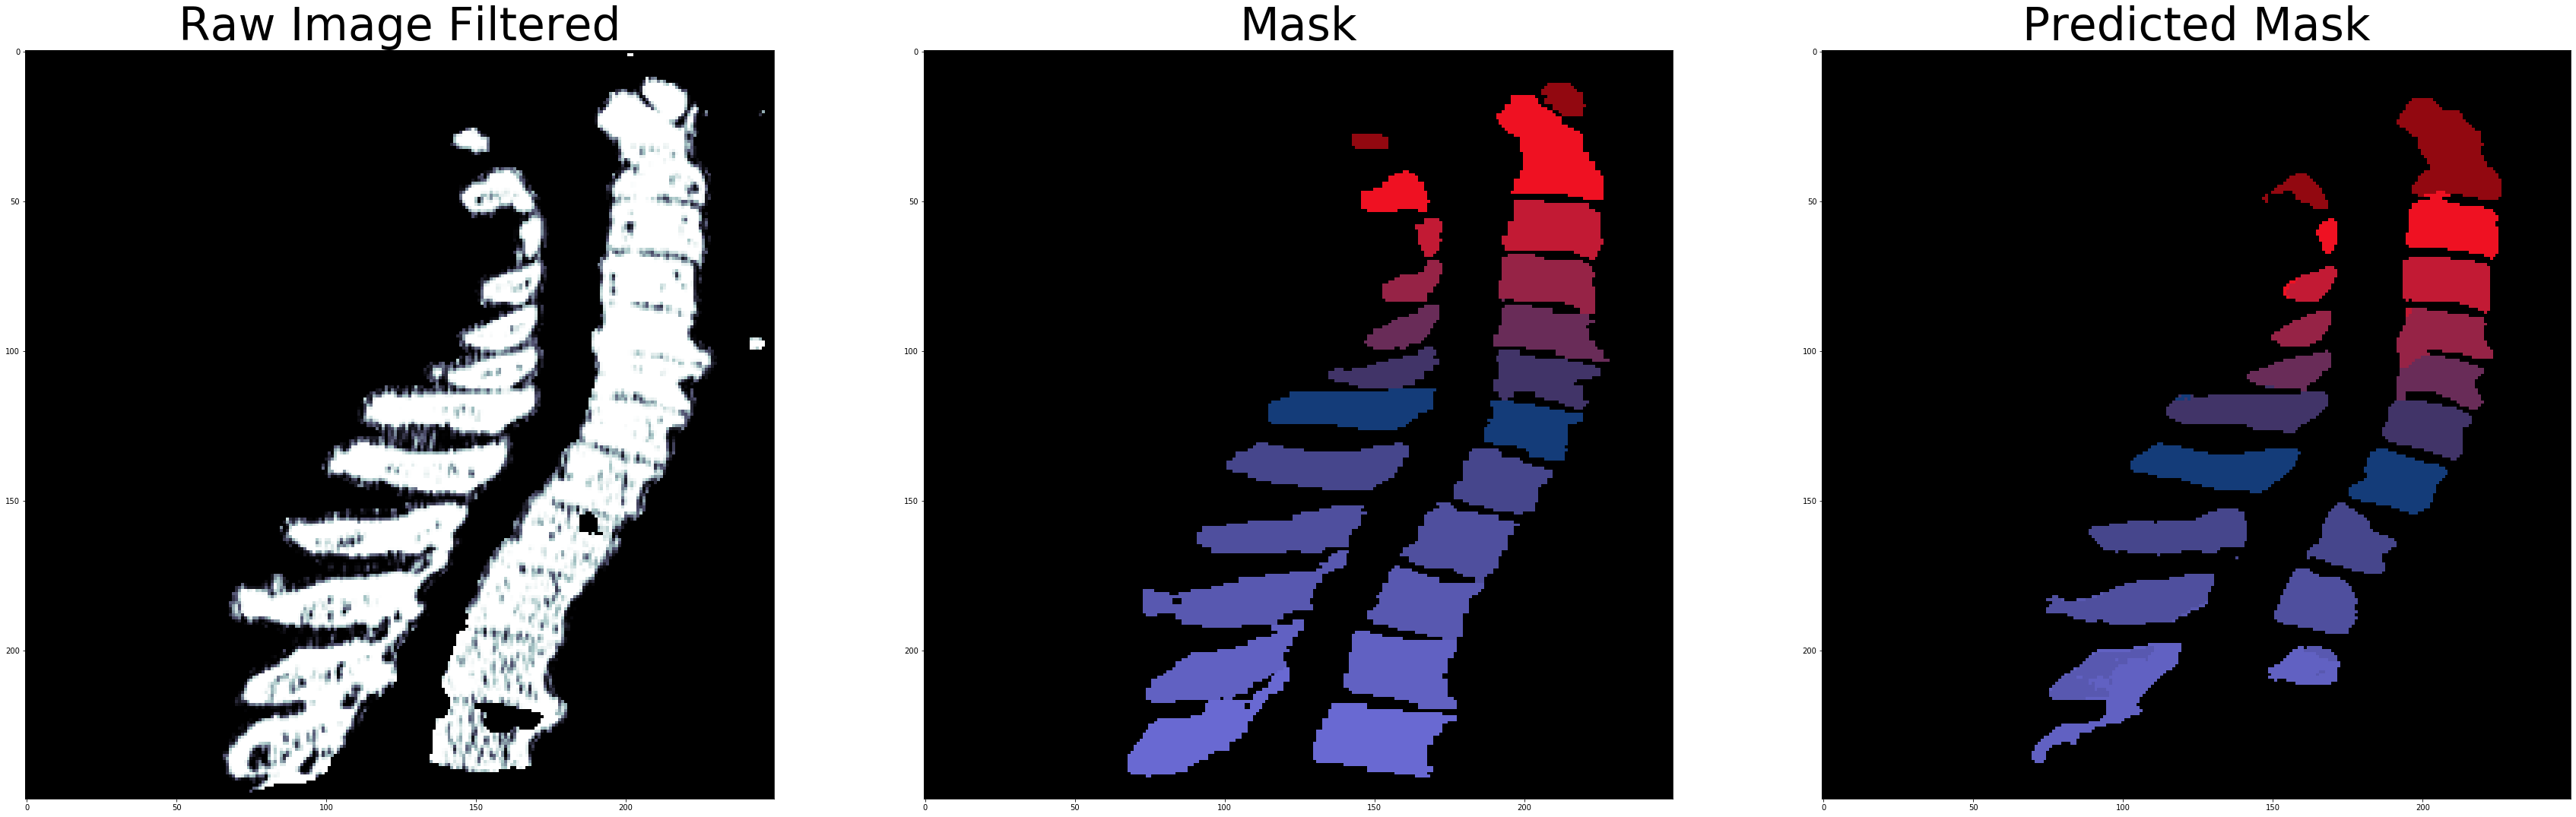

In [143]:
# Define models
model = UNet(n_channels=1, n_classes=29)
model.to(device=device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
checkpoint = torch.load("./unet_model_m_sf_intFx.pth")
model.load_state_dict(checkpoint['model_state_dict'])
model_s = UNet(n_channels=1, n_classes=2)
model_s.to(device=device)
checkpoint_s = torch.load("./unet_model_fx_4.pth")
model_s.load_state_dict(checkpoint_s['model_state_dict'])

# Predict
image = next_image['image'].to(DEVICE)
mask = next_image['mask'].long().to(DEVICE)
outputs_s = model_s(image)
outputs_s = torch.sigmoid(outputs_s)
thresh = Variable(torch.Tensor([0.05]).to(DEVICE))
outs_b = (outputs_s[:, 1, :, :].unsqueeze(1) > thresh)
image_prep_3 = torch.where(outs_b, image, outs_b.float())
outputs_m_3 = model(image_prep_3)

#Get colors
pred_mask = np.argmax(outputs_m_3.detach().cpu().numpy(), axis=1)
colors_mask, counts_mask = np.unique(next_image['mask'][0][:, :], return_counts=True)
colors, counts = np.unique(pred_mask[0], return_counts=True)
mask_dict = dict(zip(colors_mask, counts_mask))
pred_dict = dict(zip(colors, counts))
pred_dict = {key: val for key, val in pred_dict.items() if val > 100}
mask_list = [val for key, val in v_dict.items() if key in mask_dict]
pred_list = [val for key, val in v_dict.items() if key in pred_dict]
new_mask_3 = pred_mask[0] - 1

# Prints
loss = nn.CrossEntropyLoss()(outputs_m_3, mask)
train_loss = loss.item()
print("Train_loss: {0}".format(train_loss))
print(mask_list)
print(pred_list)

# Plot
fig, ax = plt.subplots(1, 3, figsize=(60, 60))
# ax[0].imshow(image[0, 0, :, :].detach().cpu().numpy(), cmap='bone', vmin=0, vmax=255)
# ax[0].set_title("Raw Image", fontsize=60)
ax[0].imshow(image_prep_3[0, 0, :, :].detach().cpu().numpy(), cmap='bone', vmin=0, vmax=255)
ax[0].set_title("Raw Image Filtered", fontsize=60)
ax[1].imshow(mask[0, :, :].cpu(), cmap='gist_stern', vmin=0, vmax=29)
ax[1].set_title("Mask", fontsize=60)
ax[2].imshow(new_mask_3, cmap='gist_stern', vmin=0, vmax=29)
ax[2].set_title("Predicted Mask", fontsize=60)
plt.show()

# Case 4

Train_loss: 0.10429617017507553
['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'T1', 'T2', 'T3', 'T4', 'T5']
['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'T1', 'T2', 'T3', 'T4', 'T5', 'T12']


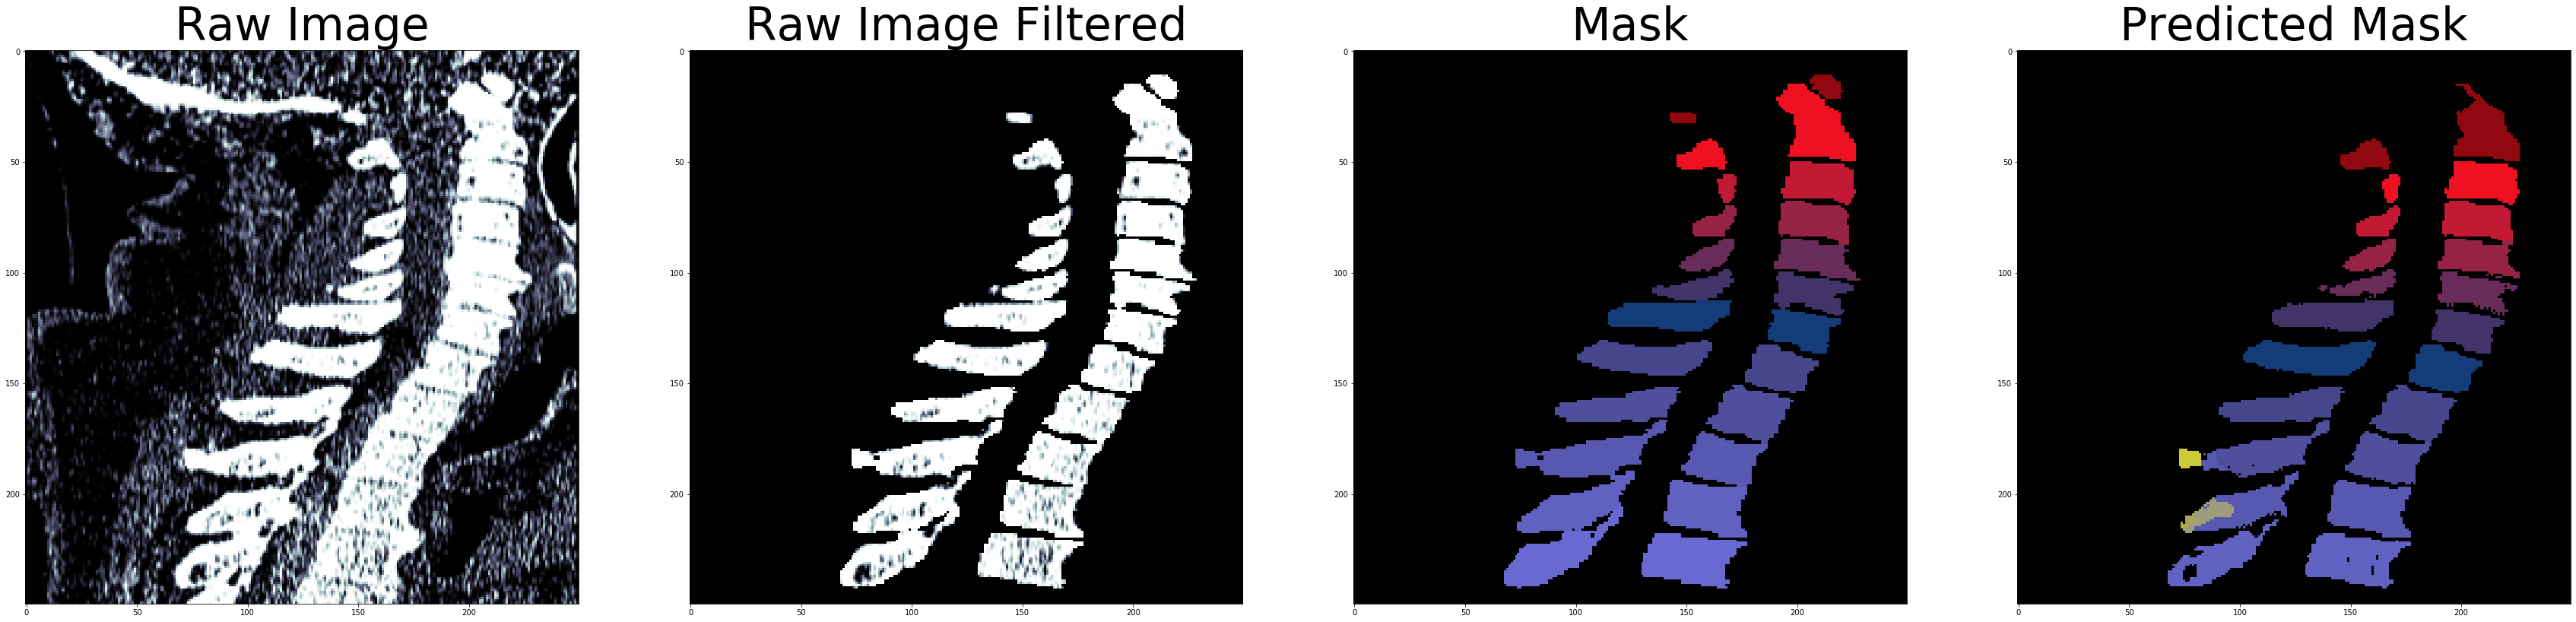

In [7]:
# Define models
model = UNet(n_channels=1, n_classes=29)
model.to(device=device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
checkpoint = torch.load("./unet_model_m_sf_t_intFx.pth")
model.load_state_dict(checkpoint['model_state_dict'])
model_s = UNet(n_channels=1, n_classes=2)
model_s.to(device=device)
checkpoint_s = torch.load("./unet_model_fx_4.pth")
model_s.load_state_dict(checkpoint_s['model_state_dict'])

# Predict
image = next_image['image'].to(DEVICE)
mask = next_image['mask'].long().to(DEVICE)
outputs_s = model_s(image)
outputs_s = torch.sigmoid(outputs_s)
thresh = Variable(torch.Tensor([0]).to(DEVICE))  # threshold
outs_b = (mask[:, :, :].unsqueeze(1) > thresh)
image_prep_4 = torch.where(outs_b, image, outs_b.float())
outputs_m_4 = model(image_prep_4)

#Get colors
pred_mask = np.argmax(outputs_m_4.detach().cpu().numpy(), axis=1)
colors_mask, counts_mask = np.unique(next_image['mask'][0][:, :], return_counts=True)
colors, counts = np.unique(pred_mask[0], return_counts=True)
mask_dict = dict(zip(colors_mask, counts_mask))
pred_dict = dict(zip(colors, counts))
pred_dict = {key: val for key, val in pred_dict.items() if val > 100}
mask_list = [val for key, val in v_dict.items() if key in mask_dict]
pred_list = [val for key, val in v_dict.items() if key in pred_dict]
new_mask_4 = pred_mask[0] - 1

# Prints
loss = nn.CrossEntropyLoss()(outputs_m_4, mask)
train_loss = loss.item()
print("Train_loss: {0}".format(train_loss))
print(mask_list)
print(pred_list)

# Plot
fig, ax = plt.subplots(1, 3, figsize=(60, 60))
# ax[0].imshow(image[0, 0, :, :].detach().cpu().numpy(), cmap='bone', vmin=0, vmax=255)
# ax[0].set_title("Raw Image", fontsize=60)
ax[0].imshow(image_prep_4[0, 0, :, :].detach().cpu().numpy(), cmap='bone', vmin=0, vmax=255)
ax[0].set_title("Raw Image Filtered", fontsize=60)
ax[1].imshow(mask[0, :, :].cpu(), cmap='gist_stern', vmin=0, vmax=29)
ax[1].set_title("Mask", fontsize=60)
ax[2].imshow(new_mask_4, cmap='gist_stern', vmin=0, vmax=29)
ax[2].set_title("Predicted Mask", fontsize=60)
plt.show()

# Case 5

Train_loss: 0.4414810538291931
['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'T1', 'T2', 'T3', 'T4', 'T5']
['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'T1', 'T2', 'T3', 'T5', 'T6', 'T12', 'L1']


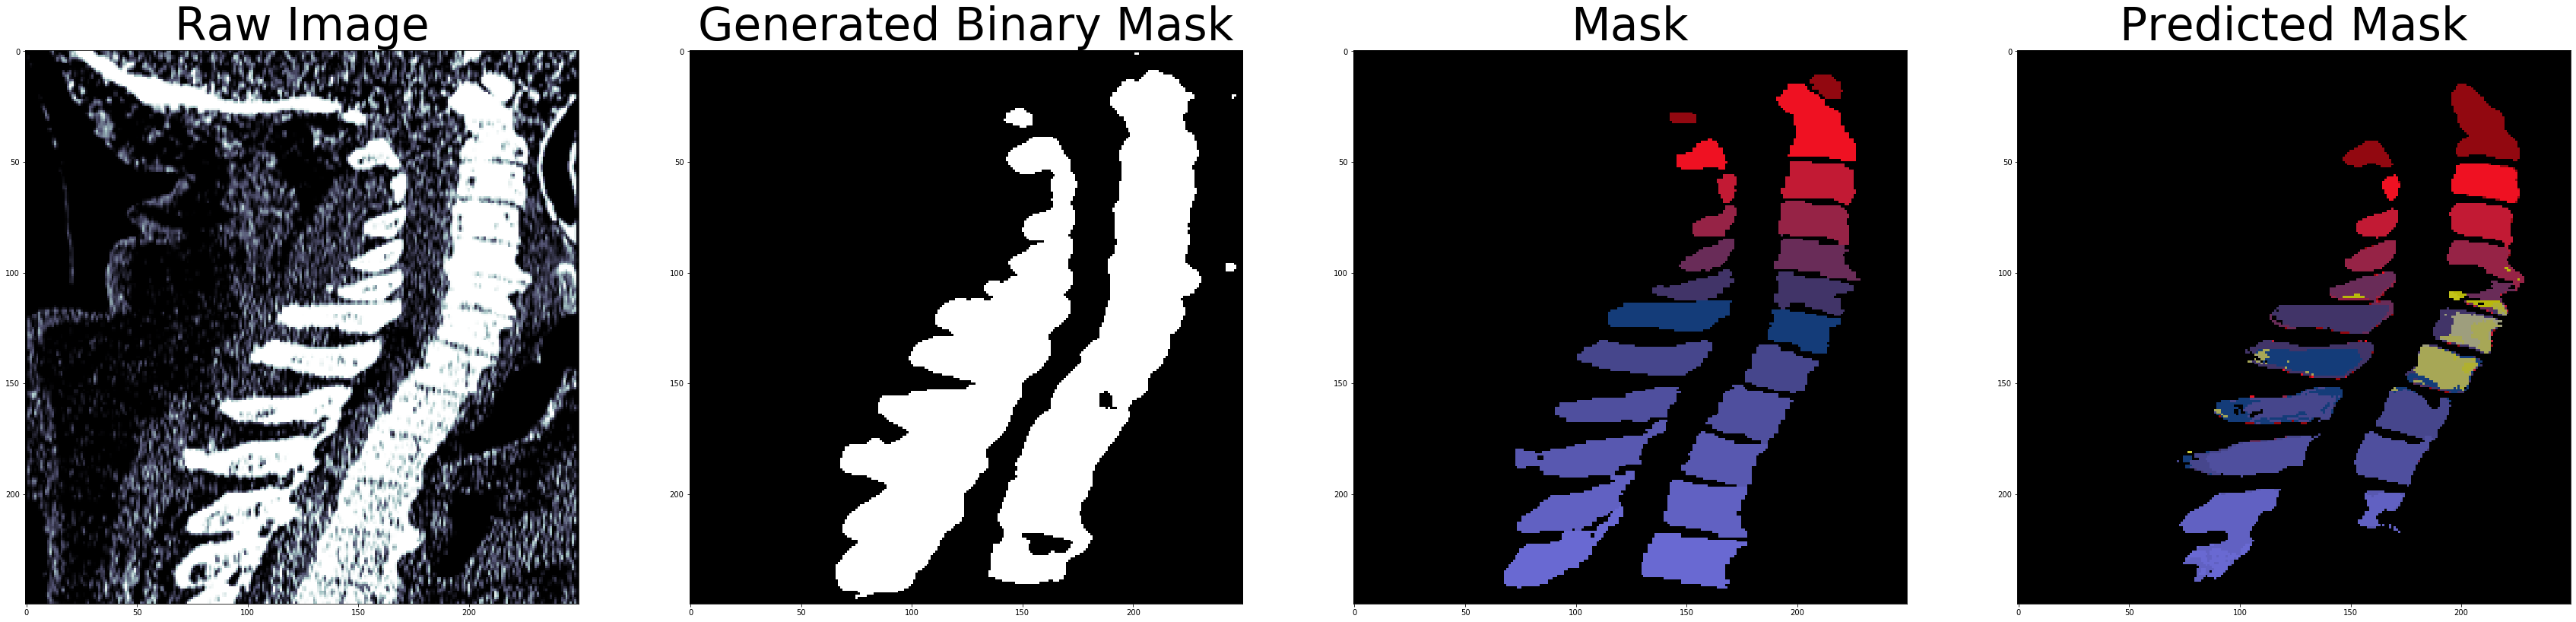

In [5]:
# Define models
model = UNet(n_channels=2, n_classes=29)
model.to(device=device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
checkpoint = torch.load("./unet_model_m_f.pth")  # Case 5
model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
model_s = UNet(n_channels=1, n_classes=2)
model_s.to(device=device)
checkpoint_s = torch.load("./unet_model_fx_4.pth")
model_s.load_state_dict(checkpoint_s['model_state_dict'])

# Predict
image = next_image['image'].to(DEVICE)
mask = next_image['mask'].long().to(DEVICE)
outputs_s = model_s(image)
outputs_s = torch.sigmoid(outputs_s)
thresh = Variable(torch.Tensor([0.05]).to(DEVICE))  # threshold
outs_b = (outputs_s[:, 1, :, :].unsqueeze(1) > thresh)
image_prep_5 = torch.cat((image, outs_b.float()), 1)
outputs_m_5 = model(image_prep_5)

#Get colors
pred_mask = np.argmax(outputs_m_5.detach().cpu().numpy(), axis=1)
colors_mask, counts_mask = np.unique(next_image['mask'][0][:, :], return_counts=True)
colors, counts = np.unique(pred_mask[0], return_counts=True)
mask_dict = dict(zip(colors_mask, counts_mask))
pred_dict = dict(zip(colors, counts))
pred_dict = {key: val for key, val in pred_dict.items() if val > 100}
mask_list = [val for key, val in v_dict.items() if key in mask_dict]
pred_list = [val for key, val in v_dict.items() if key in pred_dict]
new_mask_5 = pred_mask[0] - 1

# Prints
loss = nn.CrossEntropyLoss()(outputs_m_5, mask)
train_loss = loss.item()
print("Train_loss: {0}".format(train_loss))
print(mask_list)
print(pred_list)

# Plot
fig, ax = plt.subplots(1, 4, figsize=(60, 60))
ax[0].imshow(image[0, 0, :, :].detach().cpu().numpy(), cmap='bone', vmin=0, vmax=255)
ax[0].set_title("Raw Image", fontsize=60)
ax[1].imshow(image_prep_5[0, 1, :, :].detach().cpu().numpy(), cmap='bone', vmin=0, vmax=1)
ax[1].set_title("Generated Binary Mask", fontsize=60)
ax[2].imshow(mask[0, :, :].cpu(), cmap='gist_stern', vmin=0, vmax=29)
ax[2].set_title("Mask", fontsize=60)
ax[3].imshow(new_mask_5, cmap='gist_stern', vmin=0, vmax=29)
ax[3].set_title("Predicted Mask", fontsize=60)
plt.show()

# Loss values

In [16]:
epochs = list(range(1,6))
case1_train_nfx = [0.37840583195513533, 0.053686569913781866, 0.039664680683627246, 0.03379578147454706, 0.030264084089491175]
case1_val_nfx = [0.07707243627308087, 0.05068801674391229, 0.05034771900132926, 0.04683460643424281, 0.041885564023075604]
case2_train_nfx = [0.682280114114249, 0.08106936688467957, 0.05451767327498027, 0.04155676205245755, 0.035134997117684225]
case2_val_nfx = [0.09848511341984331, 0.058668041561284794, 0.04710958174332025, 0.041333555592085985, 0.036875347693971015]
case3_train_nfx = [0.4716800933401524, 0.05649170615801791, 0.04280750304505484, 0.03580330992228514, 0.03205490071637137]
case3_val_nfx = [0.07073094524125102, 0.05293738909288036, 0.050385980498722734, 0.04829882648210719, 0.04851401542508316]
case4_train_nfx = [0.430066790609495, 0.04189508534285575, 0.028882414806125644, 0.0236085495979235, 0.020440090002058462]
case4_val_nfx = [0.053908782979048456, 0.03704993809223215, 0.031071253105121627, 0.02882146382685215, 0.03171275745700077]
case5_train_nfx = [0.43990942353581214, 0.056407009449749745, 0.04119966509746788, 0.034852862844120744, 0.030476106676113144]
case5_val_nfx = [0.0714519936045857, 0.054374058043862694, 0.04727250879923624, 0.04780041813673306, 0.04910328984527976]

case1_train_fx = [0.5027996715396156, 0.04649670186687387, 0.027823402446012002, 0.021038398420457148, 0.01694793513278929]
case1_val_fx = [0.0649746845873532, 0.04449280762210079, 0.0437853307108055, 0.03578167507982581, 0.039009663679618944]
case2_train_fx = [0.5331427731260386, 0.0570566353955812, 0.03527751494015055, 0.025244509536297276, 0.019793497782367955]
case2_val_fx = [0.06884380623378761, 0.045562753780009756, 0.034590031232872576, 0.029894974570598642, 0.04496948379595608]
case3_train_fx = [0.5128318718961357, 0.045167852532117865, 0.03033042218996699, 0.023307963648230075, 0.019066829585812285]
case3_val_fx = [0.06838388289260759, 0.059358882014883915, 0.03985141973734624, 0.044544376339051964, 0.03984103259557558]
case4_train_fx = [0.45510167721140204, 0.031211141813418462, 0.017776948495420795, 0.012107948747990399, 0.008636018367476767]
case4_val_fx = [0.17557546986868836, 0.03875772632404614, 0.026612367905360992, 0.023202561171600196, 0.02130979240134253]
case5_train_fx = [0.5151636518117468, 0.050127667188160245, 0.033803950699110755, 0.02434187425441016, 0.019695214872425537]
case5_val_fx = [0.06338949143818108, 0.0433118536834021, 0.03505316144567449, 0.03651566874570039, 0.03854155247917049]



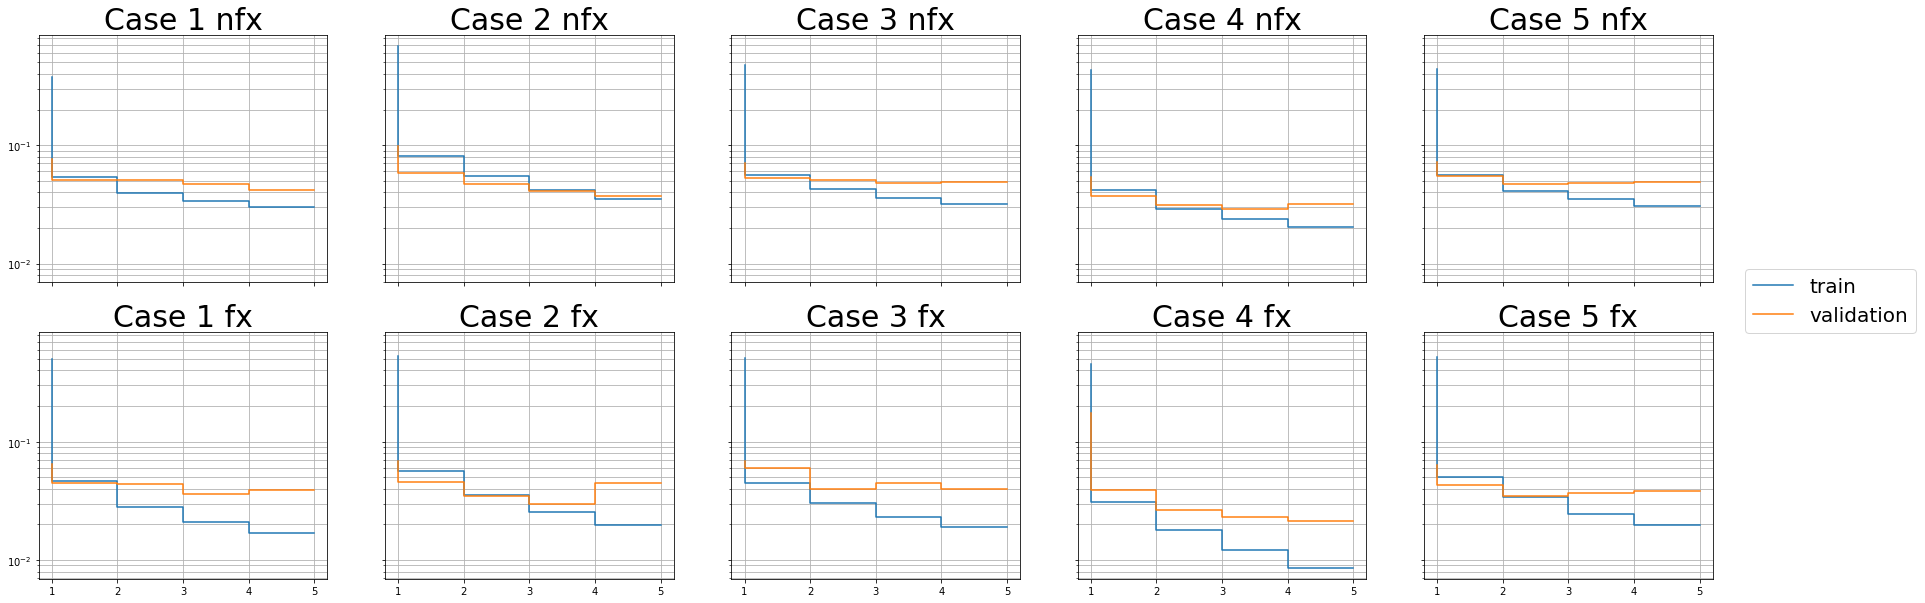

In [17]:
fig, ax = plt.subplots(2, 5, figsize=(30, 10), sharey=True, sharex=True)
ax[0][0].set_yscale('log')
ax[0][0].xaxis.set_ticks(epochs)
ax[0][0].step(epochs, case1_train_nfx, label='train')
ax[0][0].step(epochs, case1_val_nfx, label='validation')
ax[0][0].set_title("Case 1 nfx", fontsize=30)
ax[0][0].grid(which='both')
ax[0][1].step(epochs, case2_train_nfx, label='train')
ax[0][1].step(epochs, case2_val_nfx, label='validation')
ax[0][1].set_title("Case 2 nfx", fontsize=30)
ax[0][1].grid(which='both')
ax[0][2].step(epochs, case3_train_nfx, label='train')
ax[0][2].step(epochs, case3_val_nfx, label='validation')
ax[0][2].set_title("Case 3 nfx", fontsize=30)
ax[0][2].grid(which='both')
ax[0][3].step(epochs, case4_train_nfx, label='train')
ax[0][3].step(epochs, case4_val_nfx, label='validation')
ax[0][3].set_title("Case 4 nfx", fontsize=30)
ax[0][3].grid(which='both')
ax[0][4].step(epochs, case5_train_nfx, label='train')
ax[0][4].step(epochs, case5_val_nfx, label='validation')
ax[0][4].set_title("Case 5 nfx", fontsize=30)
ax[0][4].grid(which='both')
ax[1][0].step(epochs, case1_train_fx, label='train')
ax[1][0].step(epochs, case1_val_fx, label='validation')
ax[1][0].set_title("Case 1 fx", fontsize=30)
ax[1][0].grid(which='both')
ax[1][1].step(epochs, case2_train_fx, label='train')
ax[1][1].step(epochs, case2_val_fx, label='validation')
ax[1][1].set_title("Case 2 fx", fontsize=30)
ax[1][1].grid(which='both')
ax[1][2].step(epochs, case3_train_fx, label='train')
ax[1][2].step(epochs, case3_val_fx, label='validation')
ax[1][2].set_title("Case 3 fx", fontsize=30)
ax[1][2].grid(which='both')
ax[1][3].step(epochs, case4_train_fx, label='train')
ax[1][3].step(epochs, case4_val_fx, label='validation')
ax[1][3].set_title("Case 4 fx", fontsize=30)
ax[1][3].grid(which='both')
ax[1][4].step(epochs, case5_train_fx, label='train')
ax[1][4].step(epochs, case5_val_fx, label='validation')
ax[1][4].set_title("Case 5 fx", fontsize=30)
ax[1][4].grid(which='both')
handles, labels = ax[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='right', fontsize=20)
# plt.savefig('plot.jpg')
# plt.show()

(0.8, 5.2, 0.007027276774379508, 0.6551941710891999)

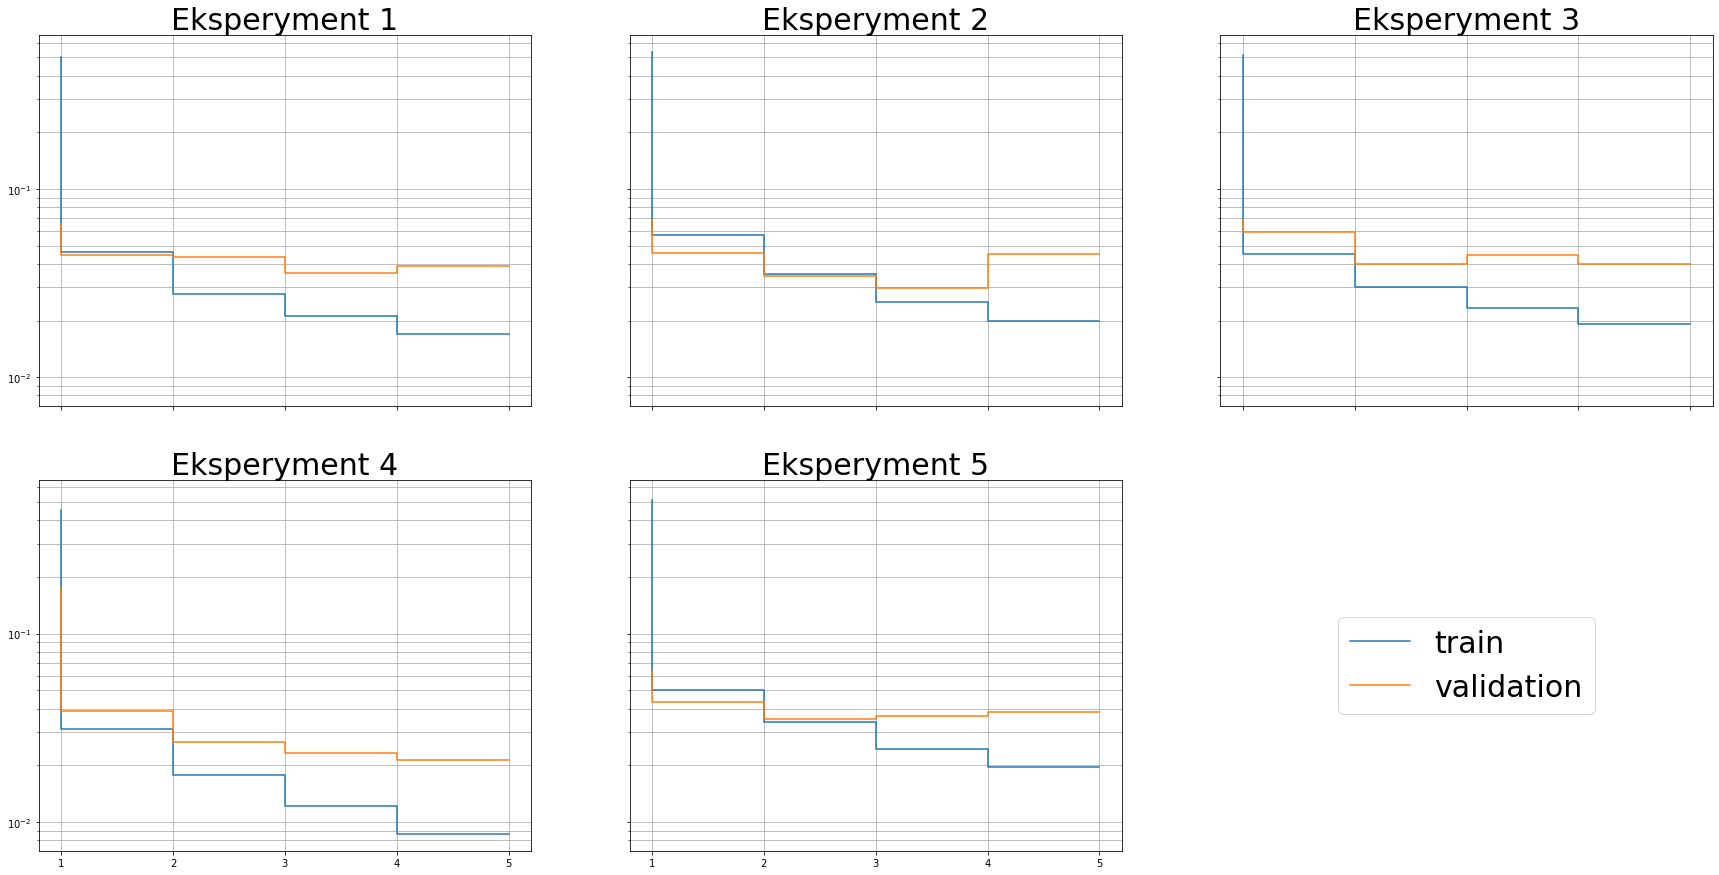

In [30]:
fig, ax = plt.subplots(2, 3, figsize=(30, 15), sharey=True, sharex=True)
ax[0][0].set_yscale('log')
ax[0][0].xaxis.set_ticks(epochs)
ax[0][0].step(epochs, case1_train_fx, label='train')
ax[0][0].step(epochs, case1_val_fx, label='validation')
ax[0][0].set_title("Eksperyment 1", fontsize=30)
ax[0][0].grid(which='both')
ax[0][1].step(epochs, case2_train_fx, label='train')
ax[0][1].step(epochs, case2_val_fx, label='validation')
ax[0][1].set_title("Eksperyment 2", fontsize=30)
ax[0][1].grid(which='both')
ax[0][2].step(epochs, case3_train_fx, label='train')
ax[0][2].step(epochs, case3_val_fx, label='validation')
ax[0][2].set_title("Eksperyment 3", fontsize=30)
ax[0][2].grid(which='both')
ax[1][0].step(epochs, case4_train_fx, label='train')
ax[1][0].step(epochs, case4_val_fx, label='validation')
ax[1][0].set_title("Eksperyment 4", fontsize=30)
ax[1][0].grid(which='both')
ax[1][1].step(epochs, case5_train_fx, label='train')
ax[1][1].step(epochs, case5_val_fx, label='validation')
ax[1][1].set_title("Eksperyment 5", fontsize=30)
ax[1][1].grid(which='both')
handles, labels = ax[0][0].get_legend_handles_labels()
ax[1][2].legend(handles, labels, loc='center', fontsize=30)
ax[1][2].axis('off')
# plt.savefig('plot.jpg')
# plt.show()

In [2]:
ex_times = [23.0, 17.0, 15.8, 18.4, 49.4]
ex_labs = ["Eksperyment 1", "Eksperyment 2", "Eksperyment 3", "Eksperyment 4", "Eksperyment 5"]

Text(0, 0.5, 'min / Epoch')

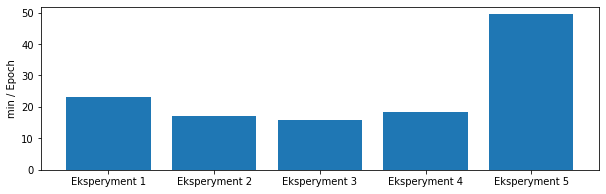

In [7]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.bar(ex_labs, ex_times)
ax.set_ylabel('min / Epoch')

In [114]:
every_train = [0.5128318718961357, 0.045167852532117865, 0.03033042218996699, 0.023307963648230075, 0.019066829585812285,
              0.016015299103472477, 0.013925991871266214, 0.012194107829866187, 0.010844211293873375, 0.010027294299460216]
every_val = [0.06838388289260759, 0.059358882014883915, 0.03985141973734624, 0.044544376339051964, 0.03984103259557558,
            0.05608402276849401, 0.04298714868560946, 0.04617542389418472, 0.04192073677668451, 0.04160860979892151]

ctr_train = [2.0162787088032426, 1.4795324134415593, 1.1244971130428643, 0.8538061503706307, 0.6440520379050025,
            0.4942941637388591, 0.38948257087633525, 0.31587705478586, 0.2622429584634715, 0.22812004258920407,
            0.1957986860311237, 0.17192969060149685, 0.1558834382429205, 0.1326297410474769, 0.11967109901637867,
            0.10522029266275208, 0.09478492835729287, 0.08378650883919206, 0.08172356918582628, 0.06874835915092764,
            0.06257023321914262, 0.05914767613184863, 0.053991643936726556, 0.05061981597401459, 0.05037570540825355,
            0.0465213602312423, 0.04710569518521942, 0.046083858654159926, 0.04484790799625475, 0.04150375364155605,
            0.033384856655551444, 0.03122622855328794, 0.030483725408477515, 0.030945633714697485, 0.02861949124630412,
            0.027423137726647586, 0.0287020247638354, 0.03537488622783587, 0.0451793548618925, 0.032413106451838695]
ctr_val = [1.6195102522247715, 1.2836787920249135, 0.958565643482041, 0.809170133711999, 0.5971090174035022,
            0.5127085311370984, 0.44185997349651235, 0.3779144455727778, 0.345806622975751, 0.32366865559628133,
            0.3157167709187457, 0.29861103468819666, 0.2816687499483426, 0.2760114754762566, 0.27755991510001193,
            0.26092517790956454, 0.2777671402222232, 0.2624005630547017, 0.2629802532886204, 0.269544480368495,
            0.25641342334187867, 0.268870218951059, 0.26767004108089104, 0.26527705275568, 0.2804459472301236,
            0.2739354614821965, 0.2772737832968695, 0.30341583797544763, 0.28290155023467123, 0.2756498323492052,
            0.2750992708627069, 0.2829561428771469, 0.29498686335915536, 0.28415229166612815, 0.29163417051824037,
            0.2898907900967619, 0.2913846685959582, 0.2960239961547287, 0.32865491962027654, 0.29547379530247364]

ctr10_train = [2.306496281642467, 1.3310614710208029, 0.7094276038696989, 0.3920954116038047, 0.24766035372158512,
               0.17226733645657077, 0.1310702214250341, 0.10123290473711677, 0.0865240290586371, 0.06995388833456673,
               0.059582674453849904, 0.060320745629724115, 0.04612027014809428, 0.04279257675079862, 0.03573014033463551,
               0.03705368891678518, 0.03441027285225573, 0.044881269335746765, 0.028582100363564678, 0.02671258330155979]
ctr10_val = [1.7390488789850973, 0.975777661895372, 0.5730623715664761, 0.381534604852893, 0.32554133922099115,
             0.277789535958216, 0.2547038425784187, 0.2601783793434441, 0.24192371798226558, 0.2426026676785186,
             0.24059981505471872, 0.24359288317451913, 0.26596902027369973, 0.2468644616182938, 0.2709097570379773,
             0.2724639796670452, 0.2926414354938079, 0.266568069568876, 0.2685225113662353, 0.27077160812765955]

ctr20p_train = [0.7568858557473123, 0.0988948086594551, 0.051281730730479064, 0.034825212441531694, 0.02578859958821794]
ctr20p_val = [0.18651091649143164, 0.14925399013230717, 0.14447022712397528, 0.14410459499664663, 0.15232309336502145]

(0.0, 1.0, 0.007640034359667082, 3.0272006548472503)

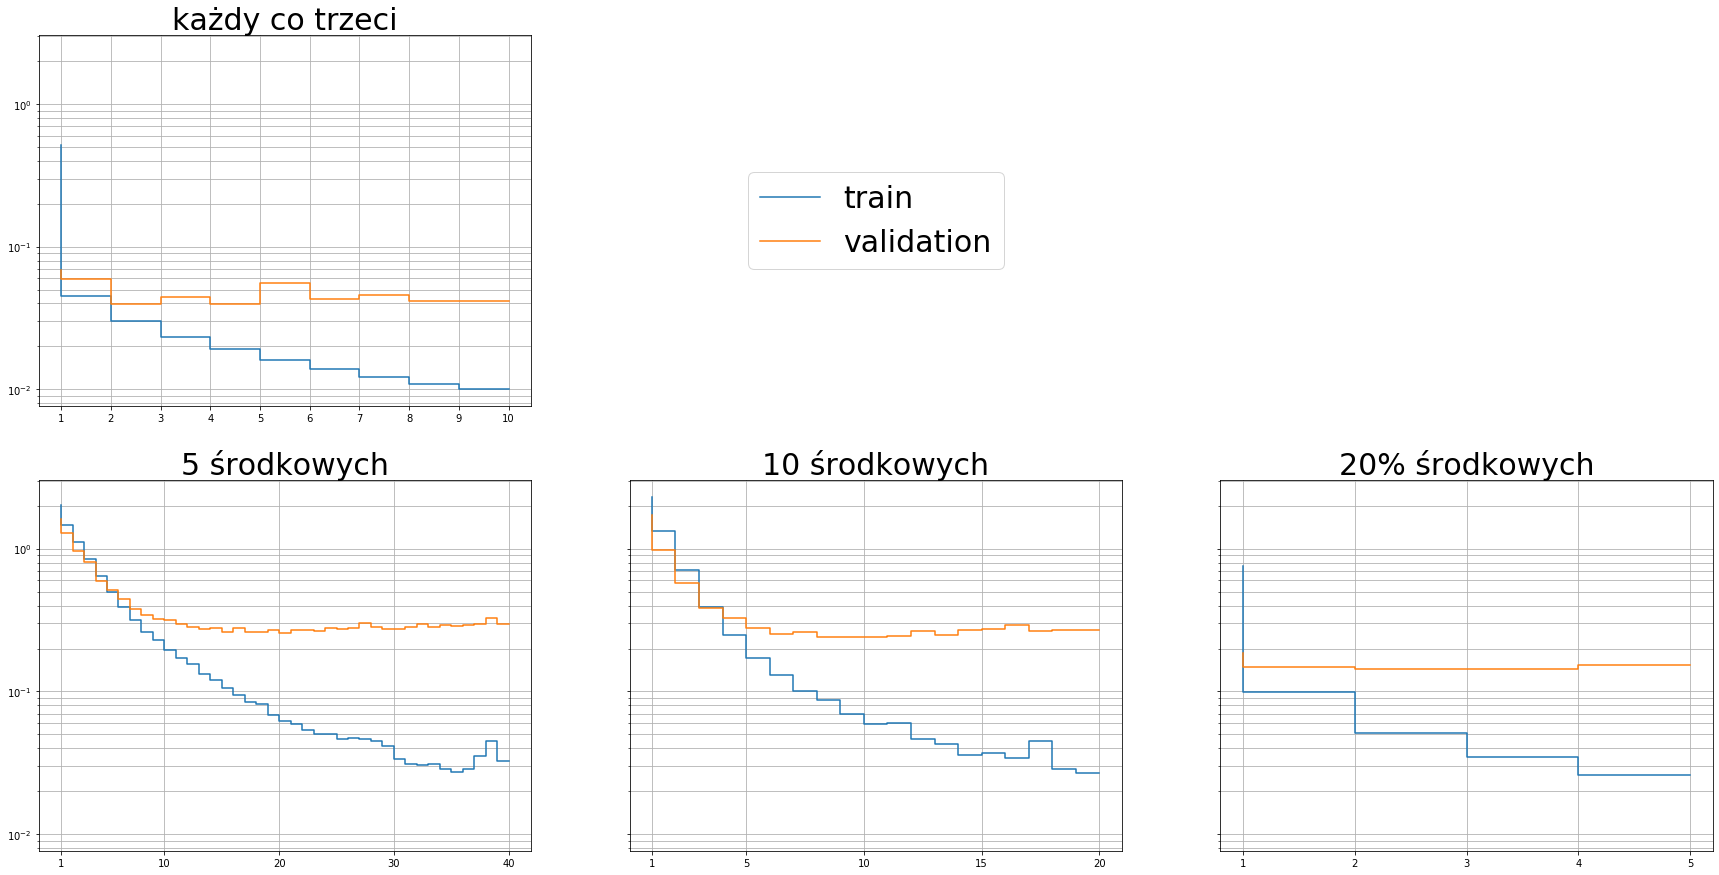

In [120]:
fig, ax = plt.subplots(2, 3, figsize=(30, 15), sharey=True, sharex=False)
ax[0][0].set_yscale('log')
ax[0][0].step(np.arange(len(every_train))+1, every_train, label='train')
ax[0][0].step(np.arange(len(every_train))+1, every_val, label='validation')
ax[0][0].set_title("każdy co trzeci", fontsize=30)
ax[0][0].grid(which='both')
ax[0][0].xaxis.set_ticks(np.arange(len(every_train))+1)
ax[1][0].step(np.arange(len(ctr_train))+1, ctr_train, label='train')
ax[1][0].step(np.arange(len(ctr_val))+1, ctr_val, label='validation')
ax[1][0].set_title("5 środkowych", fontsize=30)
ax[1][0].grid(which='both')
ax[1][0].xaxis.set_ticks([1, 10, 20, 30, 40])
ax[1][1].step(np.arange(len(ctr10_train))+1, ctr10_train, label='train')
ax[1][1].step(np.arange(len(ctr10_val))+1, ctr10_val, label='validation')
ax[1][1].set_title("10 środkowych", fontsize=30)
ax[1][1].grid(which='both')
ax[1][1].xaxis.set_ticks([1, 5, 10, 15, 20])
ax[1][2].step(np.arange(len(ctr20p_train))+1, ctr20p_train, label='train')
ax[1][2].step(np.arange(len(ctr20p_val))+1, ctr20p_val, label='validation')
ax[1][2].set_title("20% środkowych", fontsize=30)
ax[1][2].grid(which='both')
ax[1][2].xaxis.set_ticks(np.arange(len(ctr20p_train))+1)
handles, labels = ax[0][0].get_legend_handles_labels()
ax[0][1].legend(handles, labels, loc='center', fontsize=30)
ax[0][1].axis('off')
ax[0][2].axis('off')
# fig.legend(handles, labels, loc='right', fontsize=20)
# plt.savefig('plot.jpg')
# plt.show()

In [8]:
empt = []

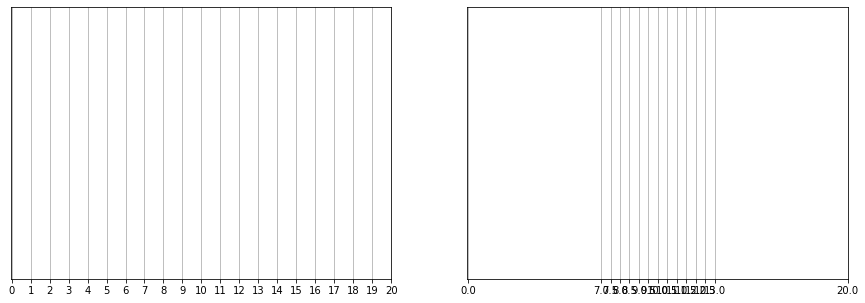

In [61]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharey=True, sharex=False)
# ax[0].set_yscale('log')
ax[0].yaxis.set_ticks(empt)
ax[0].step(empt, empt)
ax[0].set_title("", fontsize=20)
ax[0].grid(which='both', axis='x')
ax[0].xaxis.set_ticks(np.arange(21))
ax[1].step(empt, empt)
ax[1].set_title("", fontsize=20)
ax[1].grid(which='both', axis='x')
ax[1].xaxis.set_ticks([0.0, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0, 11.5, 12.0, 12.5, 13.0, 20.0])
# ax[1].xaxis.set_visible(False)

handles, labels = ax[0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='right', fontsize=20)
# plt.savefig('plot.jpg')
# plt.show()

# Single label

In [45]:
s_e4_train = [0.006185967035442259, -0.5922148259994093, -0.7475362262552371, -0.7667825413175043, -0.807498603683095,
             -0.8033800480448943, -0.8051426043843196, -0.8149575757024549, -0.8165923932701371, -0.8130570362918715,
             -0.8102043963576036, -0.8167560816519156, -0.8135812760018913, -0.8119036744237389, -0.8096009969003305]
s_e4_val = [0.477735790140230857, 0.3439045024045941, 0.3015610840382656, 0.2719062305245246, 0.260004202813868,
           0.252675058876391, 0.22615973859066985, 0.22392055876039618, 0.20135970178643559, 0.16856596380426545,
           -0.12336355926979556, 0.20615635937790044, 0.18717095411024634, 0.16124909312947786, -0.01801925258651079]

s_e3_train = [-0.6770518028304042, -0.7670183825620356, -0.7837992679909872, -0.7735927227842475, -0.7727581822510922,
             -0.7792101111074891, -0.7753236780050462, -0.7571219574179737, -0.7755944528752541, -0.7689252830444173]
s_e3_val = [0.2024091094896535, -0.047646698817400863, -0.21638735375080237, -0.2936674193305175, -0.3149508242583757,
           -0.3275068000424368, -0.32656070920345026, -0.32793063436339986, -0.32730311633470377, -0.3280269751429047]

In [42]:
s_e4_train = np.abs(s_e4_train)
s_e4_val = np.abs(s_e4_val)
s_e3_train = np.abs(s_e3_train)
s_e3_val = np.abs(s_e3_val)

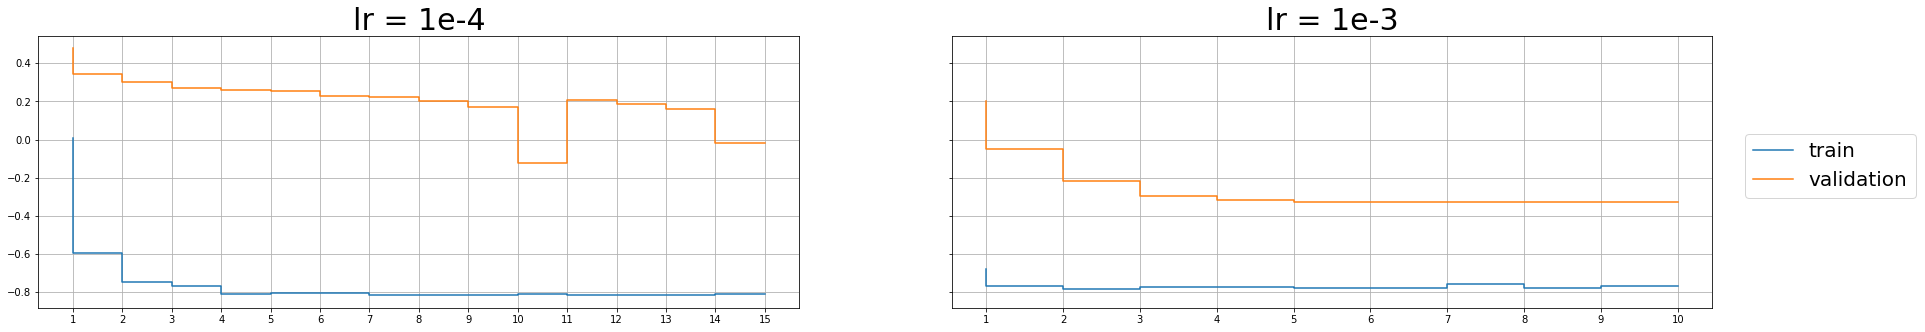

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(30, 5), sharey=True, sharex=False)
# ax[0].set_yscale('log')
ax[0].step(np.arange(len(s_e4_train))+1, s_e4_train, label='train')
ax[0].step(np.arange(len(s_e4_val))+1, s_e4_val, label='validation')
ax[0].set_title("lr = 1e-4", fontsize=30)
ax[0].grid(which='both')
ax[0].xaxis.set_ticks(np.arange(len(s_e4_train))+1)
ax[1].step(np.arange(len(s_e3_train))+1, s_e3_train, label='train')
ax[1].step(np.arange(len(s_e3_val))+1, s_e3_val, label='validation')
ax[1].set_title("lr = 1e-3", fontsize=30)
ax[1].grid(which='both')
ax[1].xaxis.set_ticks(np.arange(len(s_e3_train))+1)
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='right', fontsize=20)
# plt.savefig('plot.jpg')
# plt.show()

# Visual

In [ ]:
# Define model
model_s = UNet(n_channels=1, n_classes=2)
model_s.to(device=device)
checkpoint_s = torch.load("./unet_model_fx_4.pth")
model_s.load_state_dict(checkpoint_s['model_state_dict'])

# Predict
image = next_image['image'].to(DEVICE)
mask = next_image['mask'].long().to(DEVICE)
outputs_s = model_s(image)
outputs_s = torch.sigmoid(outputs_s)
image_prep_1 = torch.cat((image, outputs_s[:, 1, :, :].unsqueeze(1)), 1)
outputs_m_1 = model(image_prep_1)

#Get colors
pred_mask = np.argmax(outputs_m_1.detach().cpu().numpy(), axis=1)
colors_mask, counts_mask = np.unique(next_image['mask'][0][:, :], return_counts=True)
colors, counts = np.unique(pred_mask[0], return_counts=True)
mask_dict = dict(zip(colors_mask, counts_mask))
pred_dict = dict(zip(colors, counts))
pred_dict = {key: val for key, val in pred_dict.items() if val > 100}
mask_list = [val for key, val in v_dict.items() if key in mask_dict]
pred_list = [val for key, val in v_dict.items() if key in pred_dict]
new_mask_1 = pred_mask[0] - 1

# Prints
loss = nn.CrossEntropyLoss()(outputs_m_1, mask)
train_loss = loss.item()
print("Train_loss: {0}".format(train_loss))
print(mask_list)
print(pred_list)

# Plot
fig, ax = plt.subplots(1, 4, figsize=(60, 60))
ax[0].imshow(image[0, 0, :, :].detach().cpu().numpy(), cmap='bone', vmin=0, vmax=255)
ax[0].set_title("Raw Image", fontsize=60)
ax[1].imshow(image_prep_1[0, 1, :, :].detach().cpu().numpy(), cmap='bone', vmin=0, vmax=1)
ax[1].set_title("Generated Binary Mask", fontsize=60)
ax[2].imshow(mask[0, :, :].cpu(), cmap='gist_stern', vmin=0, vmax=29)
ax[2].set_title("Mask", fontsize=60)
ax[3].imshow(new_mask_1, cmap='gist_stern', vmin=0, vmax=29)
ax[3].set_title("Predicted Mask", fontsize=60)
plt.show()

# ehh

In [10]:
eccs = [52.6, 48.2, 44.7, 46.4]
ex_labs = ["każdy co trzeci", "5 środkowych", "10 środkowych", "20% środkowych"]

Text(0, 0.5, 'Acc [%]')

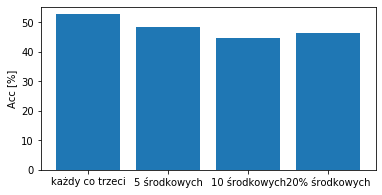

In [108]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.bar(ex_labs, eccs)
ax.set_ylabel('Acc [%]')

In [3]:
ells1 = [0.3141429388666885, 0.2950279094409524, 0.2806407084623188, 0.355614819633366]
ells5 = [0.30881137063955527, 0.2948664319031594, 0.28129742136878666, 0.3510185769260779]
ells10 = [0.29792206313726943, 0.28774427398861024, 0.27405710079435386, 0.33997556700243464]
ex_labs = ["każdy co trzeci", "5 środkowych", "10 środkowych", "20% środkowych"]

Text(0.5, 0, 'Zbiór uczący')

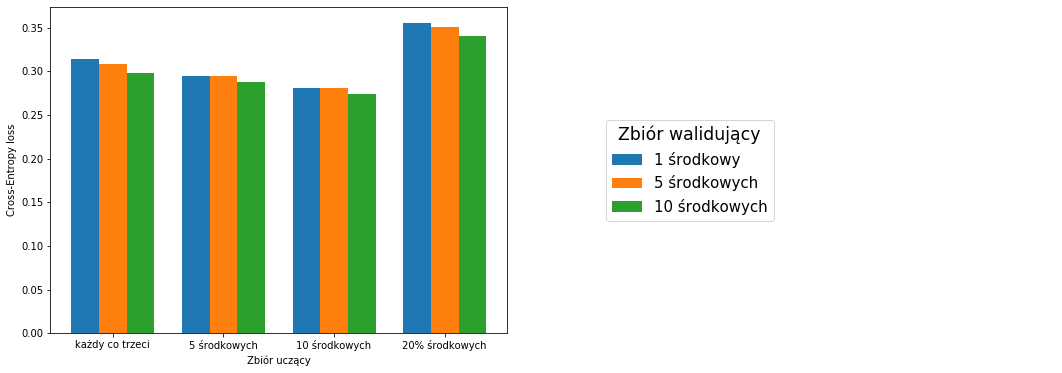

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
barWidth = 0.25
br1 = np.arange(4)
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
ax[0].bar(br1, ells1, label="1 środkowy", width = barWidth)
ax[0].bar(br2, ells5, label="5 środkowych", width = barWidth)
ax[0].bar(br3, ells10, label="10 środkowych", width = barWidth)

handles, labels = ax[0].get_legend_handles_labels()
ax[1].legend(handles, labels, loc='center left', fontsize=15, title="Zbiór walidujący", title_fontsize="xx-large")
ax[1].axis('off')
ax[0].xaxis.set_ticks([r + barWidth for r in range(4)])
ax[0].set_xticklabels(ex_labs)
# fig.legend(handles, labels, loc='right', bbox_to_anchor=(1.0, 0.5), fontsize=10, )
ax[0].set_ylabel('Cross-Entropy loss')
ax[0].set_xlabel('Zbiór uczący')

In [12]:
accs = [57.0, 61.4, 52.6, 33.3, 28.0]
ax_labs = ["Eksperyment 1", "Eksperyment 2", "Eksperyment 3", "Eksperyment 4", "Eksperyment 5"]

Text(0, 0.5, 'Acc %')

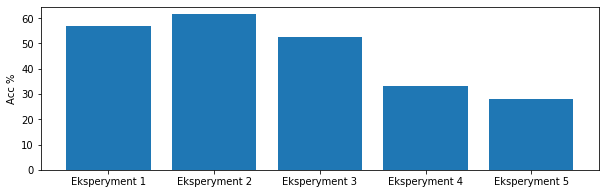

In [14]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.bar(ax_labs, accs)
ax.set_ylabel('Acc %')